In [1]:
import torch, platform, sys
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: 3.12.11
PyTorch: 2.9.0
CUDA available: False


In [2]:
#!pip -q install kaggle torch torchvision matplotlib


In [3]:
# route set up
from pathlib import Path

# 自动识别当前脚本是在 notebooks/ 还是根目录
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "celeba"

# 创建数据目录
DATA_DIR.mkdir(parents=True, exist_ok=True)
print("📂 Dataset directory:", DATA_DIR)

📂 Dataset directory: /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/data/celeba


In [4]:
#set up the kaggle.json(local)
from pathlib import Path
import os, shutil

#1.The path of kaggle.json
KAGGLE_TOKEN = Path(".kaggle/kaggle.json") 
#use google colab
# if not KAGGLE_TOKEN.exists():
#     from google.colab import files
#     print(" Upload your Kaggle API token (kaggle.json). Get it from Kaggle: Account → Create New API Token.")
#     uploaded = files.upload()
#     os.makedirs("/root/.kaggle", exist_ok=True)
#     Path("kaggle.json").rename(KAGGLE_TOKEN)
#     KAGGLE_TOKEN.chmod(0o600)
# print("Kaggle token ready ")

#2. The path officially required by kaggle
KAGGLE_DIR = Path.home() / ".kaggle"
KAGGLE_DIR.mkdir(exist_ok=True)
TARGET = KAGGLE_DIR / "kaggle.json"

if not TARGET.exists():
    if LOCAL_KAGGLE_JSON.exists():
        shutil.copy(LOCAL_KAGGLE_JSON, TARGET)
        TARGET.chmod(0o600)
        print(f"✅ Copied kaggle.json to {TARGET}")
    else:
        raise FileNotFoundError("kaggle.json not found in project root.")
else:
    print(f"✅ Kaggle token already exists at {TARGET}")

✅ Kaggle token already exists at /Users/liangwenlong/.kaggle/kaggle.json


In [5]:
# USE_DRIVE = False

# if USE_DRIVE:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     DATA_DIR = Path("/content/drive/MyDrive/celeba")
# else:
#     DATA_DIR = Path("/content/celeba")

# print("Data root:", DATA_DIR)


In [6]:
# Clean and re-create folder
import shutil
from pathlib import Path
import os


# the path of the dataset
#%%
# --- Step 2. 下载 CelebA 数据集（使用 kagglehub） ---
!pip install kagglehub -q

import kagglehub
import shutil

print("📥 Downloading CelebA dataset from KaggleHub ...")
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("✅ Download complete!")
print("📂 Files downloaded to:", path)

# 把下载的文件复制到统一的数据路径
shutil.copytree(path, DATA_DIR, dirs_exist_ok=True)
print("✅ Dataset moved to:", DATA_DIR)


# # unzip the dataset
# zip_path = DATA_DIR / "celeba-dataset.zip"
# if zip_path.exists():
#     import zipfile
#     with zipfile.ZipFile(zip_path, "r") as zf:
#         zf.extractall(DATA_DIR)
#     print("✅ Unzipped to", DATA_DIR)
# else:
#     print("⚠️ zip file not found, check kaggle download output.")


📥 Downloading CelebA dataset from KaggleHub ...


/Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Download complete!
📂 Files downloaded to: /Users/liangwenlong/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2
✅ Dataset moved to: /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/data/celeba


In [7]:
from pathlib import Path

# 如果当前在 notebooks/ 里，就回到上一层项目根目录
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "celeba"

img_folder = DATA_DIR / "img_align_celeba"
n_imgs = len(list(img_folder.glob("*.jpg")))
print("📸 Total images:", n_imgs)
print("📂 Checking in:", img_folder)


📸 Total images: 202599
📂 Checking in: /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/data/celeba/img_align_celeba


In [8]:
import os
print(os.getcwd())


/Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/notebooks


In [9]:
import zipfile
from pathlib import Path

# 解压 celeba 中的所有 zip 文件（如果有的话）
if any(DATA_DIR.rglob("*.zip")):
    print("🗜️ Found zip files, starting to unzip...")
    unzip_all(DATA_DIR)
else:
    print("✅ No zip files found, skipping unzip step.")


✅ No zip files found, skipping unzip step.


In [10]:
IMG_DIR = DATA_DIR / "img_align_celeba"
N_IMGS = len(list(IMG_DIR.glob("*.jpg")))
print("Using image folder:", IMG_DIR)
print("Total JPGs:", N_IMGS)


Using image folder: /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/data/celeba/img_align_celeba
Total JPGs: 202599


In [11]:
from pathlib import Path
from PIL import Image
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#  Path to extracted CelebA images
IMG_DIR = DATA_DIR / "img_align_celeba"

assert IMG_DIR.exists(), f" Folder not found: {IMG_DIR}"
print(f" Found folder: {IMG_DIR}")
print(f" Total JPGs: {len(list(IMG_DIR.glob('*.jpg')))}")
# --- Transformations ---
HR_SIZE = 128
SCALE   = 2
LR_SIZE = HR_SIZE // SCALE
hr_tf = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize((HR_SIZE, HR_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])
to_pil = transforms.ToPILImage()
lr_from_hr = transforms.Compose([
    transforms.Resize((LR_SIZE, LR_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])
# --- CelebA class ---
class CelebASR(Dataset):                                         #This is  pytorch custom dataset
    def __init__(self, img_dir: Path):
        self.paths = sorted(img_dir.glob("*.jpg"))
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {img_dir}")
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        pil = Image.open(self.paths[i]).convert("RGB")
        hr  = hr_tf(pil)
        lr  = lr_from_hr(to_pil(hr))
        return lr, hr

sr_ds = CelebASR(IMG_DIR)
print(f" Dataset ready: {len(sr_ds)} images")


 Found folder: /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA/data/celeba/img_align_celeba
 Total JPGs: 202599
 Dataset ready: 202599 images


In [12]:
from torch.utils.data import DataLoader

num_workers = 2 if torch.cuda.is_available() else 0
pin_memory = torch.cuda.is_available()    

sr_loader = DataLoader(sr_ds, batch_size=16, shuffle=True, num_workers=num_workers)   #if using a GPU set num_workers to 2, if using a Macbook set it to 0 
                                                                                                  #if using GPU add pin_memory=True insr_loader
print(" DataLoader ready")


 DataLoader ready


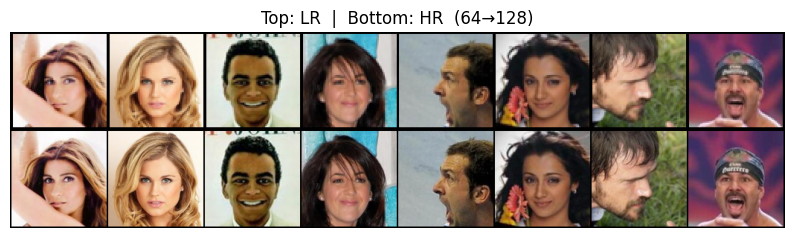

In [13]:
from torchvision import utils
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

lr_batch, hr_batch = next(iter(sr_loader))

# Make separate grids
grid_lr = utils.make_grid(lr_batch[:8], nrow=8, padding=2)
grid_hr = utils.make_grid(hr_batch[:8], nrow=8, padding=2)

# Upsample LR grid to match HR grid height/width
grid_lr_up = F.interpolate(grid_lr.unsqueeze(0), size=grid_hr.shape[-2:], mode="nearest").squeeze(0)

grid = torch.cat([grid_lr_up, grid_hr], dim=1)

plt.figure(figsize=(10,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title(f"Top: LR  |  Bottom: HR  ({lr_batch.shape[-1]}→{hr_batch.shape[-1]})")
plt.show()


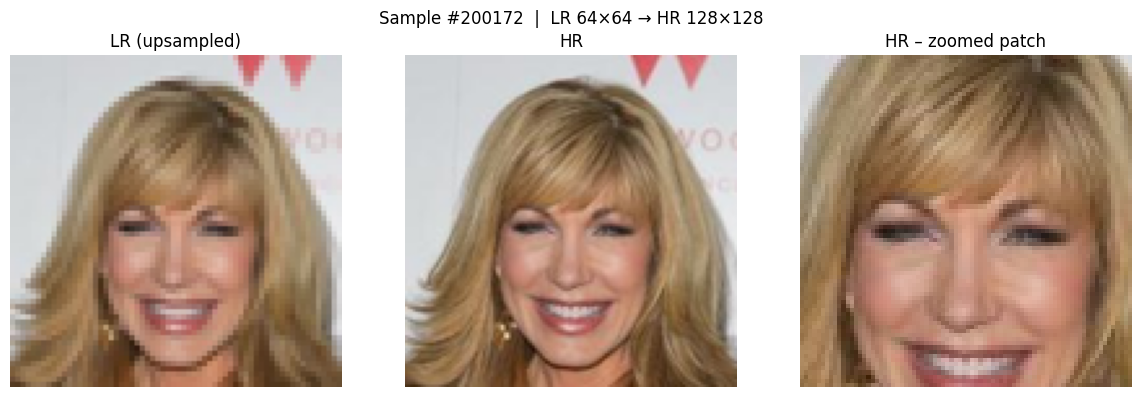

In [ ]:
import matplotlib.pyplot as plt
import torch, torch.nn.functional as F

# pick one random sample
i = torch.randint(0, len(sr_ds), (1,)).item()
lr, hr = sr_ds[i]
lr_up = F.interpolate(lr.unsqueeze(0), size=hr.shape[-2:], mode="nearest").squeeze(0)

# choose a patch window
H, W = hr.shape[-2:]
cy, cx, win = H//2, W//2, 40
sl = slice(cy-win, cy+win), slice(cx-win, cx+win)

#plot
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(lr_up.permute(1,2,0));               ax[0].set_title("LR (upsampled)"); ax[0].axis("off")
ax[1].imshow(hr.permute(1,2,0));                  ax[1].set_title("HR");             ax[1].axis("off")
ax[2].imshow(hr[:,sl[0],sl[1]].permute(1,2,0));   ax[2].set_title("HR – zoomed patch"); ax[2].axis("off")
plt.suptitle(f"Sample #{i}  |  LR {lr.shape[-1]}×{lr.shape[-2]} → HR {hr.shape[-1]}×{hr.shape[-2]}")
plt.tight_layout()   #能防止标题和图挤在一起，截图好看。
plt.show()   #有的环境不自动 show（比如脚本跑），plt.show就能看到图


In [15]:
print("Total images in dataset:", len(sr_ds))
print("LR batch:", tuple(lr_batch.shape), "HR batch:", tuple(hr_batch.shape))


Total images in dataset: 202599
LR batch: (16, 3, 64, 64) HR batch: (16, 3, 128, 128)


In [ ]:
import torch
from torch.utils.data import Subset

# reproducible split
N = len(sr_ds)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(N, generator=g)

# ratios
test_ratio, val_ratio = 0.05, 0.05
test_size = int(N * test_ratio)
val_size  = int(N * val_ratio)
train_size = N - val_size - test_size

# split indices
train_idx = perm[:train_size]
val_idx   = perm[train_size:train_size+val_size]
test_idx  = perm[train_size+val_size:]

# create subsets
train_ds = Subset(sr_ds, train_idx.tolist())
val_ds   = Subset(sr_ds, val_idx.tolist())
test_ds  = Subset(sr_ds, test_idx.tolist())

print(f"Split sizes  ▶  train: {len(train_ds)}  val: {len(val_ds)}  test: {len(test_ds)}")


Split sizes  ▶  train: 182341  val: 10129  test: 10129


In [18]:
#use for google.colab
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# out_dir = "/content/drive/MyDrive/celeba/final_tensors_sharded"
# os.makedirs(out_dir, exist_ok=True)

# print(" Output folder ready:", out_dir)

#use for local
from pathlib import Path

out_dir = Path("./outputs/final_tensors_sharded")
out_dir.mkdir(parents=True, exist_ok=True)
print("✅ Output folder ready:", out_dir)




✅ Output folder ready: outputs/final_tensors_sharded


In [ ]:
import os, json
from pathlib import Path
import torch
from torch.utils.data import DataLoader

def to_uint8(x):
    return (x.mul(255).clamp(0,255)).to(torch.uint8)

out_dir = Path("/content/celeba/final_tensors_sharded_fast")
out_dir.mkdir(parents=True, exist_ok=True)

def save_split_tensors_streaming(
    split_ds, name, out_dir,
    batch_size=16,
    shard_size=4096,
    num_workers=0,
    max_items=None,
):
    dl = DataLoader(
        split_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=False, persistent_workers=False
    )

    shard_idx, n_total = 0, 0
    buf_lr, buf_hr = [], []

    for lr, hr in dl:
        buf_lr.append(lr)
        buf_hr.append(hr)
        n_total += lr.size(0)

        cur = sum(x.size(0) for x in buf_lr)
        flush = cur >= shard_size
        if max_items is not None and n_total >= max_items:
            flush = True

        if flush:
            lr_cat = torch.cat(buf_lr, dim=0)
            hr_cat = torch.cat(buf_hr, dim=0)
            if max_items is not None:
                overflow = n_total - max_items
                if overflow > 0:
                    keep = lr_cat.size(0) - overflow
                    lr_cat = lr_cat[:keep]
                    hr_cat = hr_cat[:keep]
                    n_total = max_items

            torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
            torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
            shard_idx += 1
            buf_lr, buf_hr = [], []

        if max_items is not None and n_total >= max_items:
            break
    if buf_lr and (max_items is None or n_total < max_items):
        lr_cat = torch.cat(buf_lr, dim=0)
        hr_cat = torch.cat(buf_hr, dim=0)
        torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
        torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
        shard_idx += 1

    manifest = {
        "name": name, "count": n_total,
        "batch_size": batch_size, "shard_size": shard_size,
        "num_shards": shard_idx,
        "dtype": "uint8(0-255), RGB, CxHxW",
        "pattern_lr": f"lr_{name}_*.pt",
        "pattern_hr": f"hr_{name}_*.pt",
    }
    with open(out_dir / f"manifest_{name}.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print(f"✔ Saved {name}: {n_total} items into {manifest['num_shards']} shard(s)")
    return manifest


train_manifest = save_split_tensors_streaming(train_ds, "train", out_dir,
                                              batch_size=16, shard_size=4096,
                                              num_workers=0, max_items=None)
val_manifest   = save_split_tensors_streaming(val_ds, "val", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)
test_manifest  = save_split_tensors_streaming(test_ds, "test", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)

print("All done. Shards at:", out_dir)


In [19]:
import os, json
from pathlib import Path
import torch
from torch.utils.data import DataLoader

def to_uint8(x):
    return (x.mul(255).clamp(0,255)).to(torch.uint8)

# ✅ 修改为本地输出路径
out_dir = Path("./outputs/final_tensors_sharded")
out_dir.mkdir(parents=True, exist_ok=True)

def save_split_tensors_streaming(
    split_ds, name, out_dir,
    batch_size=16,
    shard_size=4096,
    num_workers=0,
    max_items=None,
):
    dl = DataLoader(
        split_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=False, persistent_workers=False
    )

    shard_idx, n_total = 0, 0
    buf_lr, buf_hr = [], []

    for lr, hr in dl:
        buf_lr.append(lr)
        buf_hr.append(hr)
        n_total += lr.size(0)

        cur = sum(x.size(0) for x in buf_lr)
        flush = cur >= shard_size
        if max_items is not None and n_total >= max_items:
            flush = True

        if flush:
            lr_cat = torch.cat(buf_lr, dim=0)
            hr_cat = torch.cat(buf_hr, dim=0)
            if max_items is not None:
                overflow = n_total - max_items
                if overflow > 0:
                    keep = lr_cat.size(0) - overflow
                    lr_cat = lr_cat[:keep]
                    hr_cat = hr_cat[:keep]
                    n_total = max_items

            torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
            torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
            shard_idx += 1
            buf_lr, buf_hr = [], []

        if max_items is not None and n_total >= max_items:
            break

    if buf_lr and (max_items is None or n_total < max_items):
        lr_cat = torch.cat(buf_lr, dim=0)
        hr_cat = torch.cat(buf_hr, dim=0)
        torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
        torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
        shard_idx += 1

    manifest = {
        "name": name, "count": n_total,
        "batch_size": batch_size, "shard_size": shard_size,
        "num_shards": shard_idx,
        "dtype": "uint8(0-255), RGB, CxHxW",
        "pattern_lr": f"lr_{name}_*.pt",
        "pattern_hr": f"hr_{name}_*.pt",
    }
    with open(out_dir / f"manifest_{name}.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print(f"✔ Saved {name}: {n_total} items into {manifest['num_shards']} shard(s)")
    return manifest


train_manifest = save_split_tensors_streaming(train_ds, "train", out_dir,
                                              batch_size=16, shard_size=4096,
                                              num_workers=0, max_items=None)
val_manifest   = save_split_tensors_streaming(val_ds, "val", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)
test_manifest  = save_split_tensors_streaming(test_ds, "test", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)

print("✅ All done. Shards at:", out_dir)


✔ Saved train: 182341 items into 45 shard(s)
✔ Saved val: 10129 items into 5 shard(s)
✔ Saved test: 10129 items into 5 shard(s)
✅ All done. Shards at: outputs/final_tensors_sharded


In [ ]:
# prepare 9 samples for bicubc baseline
from pathlib import Path
import os
import cv2

# notebook 在 notebooks/ 里，所以项目根目录就是上一级
BASE_DIR = Path.cwd().parent
print("BASE_DIR =", BASE_DIR)

celeba_img_dir = BASE_DIR / "data" / "celeba" / "img_align_celeba"
hr_dir = BASE_DIR / "data" / "samples" / "HR"
lr_dir = BASE_DIR / "data" / "samples" / "LR"

print("CelebA img dir exists? ", celeba_img_dir.exists())

hr_dir.mkdir(parents=True, exist_ok=True)
lr_dir.mkdir(parents=True, exist_ok=True)

count = 0
for fname in sorted(os.listdir(celeba_img_dir))[:10]:
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = celeba_img_dir / fname
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # 保存 HR 原图
    cv2.imwrite(str(hr_dir / fname), img)

    # 生成 LR（缩小一半）
    h, w = img.shape[:2]
    lr = cv2.resize(img, (w // 2, h // 2), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(str(lr_dir / fname), lr)

    count += 1

print(f"Prepared {count} sample pairs in data/samples/(HR|LR)")


BASE_DIR = /Users/liangwenlong/study/bme/3/DeepLearning/Topic/SGN/celebA
CelebA img dir exists?  True
Prepared 9 sample pairs in data/samples/(HR|LR)
